In [1]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt

plt.style.use("seaborn-white")
import seaborn as sns

sns.set_style("white")

from sklearn.model_selection import train_test_split

from torch import nn

from tqdm import tqdm
from torch.nn import Sequential

In [2]:
from image_processing import upsample, downsample
from data import prepare_data, test_images_path, load_images_as_arrays, TGSSaltDataset
from visualisation import (
    plot_coverage_and_coverage_class,
    scatter_coverage_and_coverage_class,
    plot_depth_distributions,
    plot_predictions,
    plot_images,
)
from model import model_path, save_checkpoint, update_state
from metrics import iou_metric_batch, my_iou_metric
from toolz import compose
from data import rle_encode
import datetime
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch

from torch.utils import data

from resnetlike import UNetResNet
from training import train, test
from collections import defaultdict
import logging
import random
from utils import create_optimizer, tboard_log_path
import uuid
import itertools as it
from operator import itemgetter
import shutil
from losses import lovasz_hinge


In [3]:
now = datetime.datetime.now()

In [4]:
img_size_target = 101
batch_size = 128
learning_rate = 0.1
epochs = 70
num_workers = 0
seed = 42
num_cycles = (
    6
)  # Using Cosine Annealing with warm restarts, the number of times to oscillate
notebook_id = f"{now:%d%b%Y}_{uuid.uuid4()}"
base_channels = 32
config = {
    "run_config": {
        "arch": "shake_shake",
        "base_channels": 64,
        "depth": 26,
        "shake_forward": True,
        "shake_backward": True,
        "shake_image": True,
        "input_shape": (1, 1, img_size_target, img_size_target),
    },
    "optim_config": {
        "optimizer": "sgd",
        "base_lr": learning_rate,
        "momentum": 0.9,
        "weight_decay": 1e-4,
        "nesterov": True,
        "epochs": epochs,
        "scheduler": "cosine",
        "lr_min": 0,
    },
}

In [5]:
logging.basicConfig(level=logging.INFO)
torch.backends.cudnn.benchmark = True
logger = logging.getLogger(__name__)
logger.info(f"Started {now}")
tboard_log = os.path.join(tboard_log_path(), f"log_{notebook_id}")
logger.info(f"Writing TensorBoard logs to {tboard_log}")
summary_writer = None  # SummaryWriter(log_dir=tboard_log)

INFO:__main__:Started 2018-09-27 15:55:08.504251
INFO:__main__:Writing TensorBoard logs to /mnt/models/logs/pytorch_unet_resnetlike/9a38ca04ff2caea5b50ceda24bcb763027816de0/log_27Sep2018_fcbdb748-3ad5-4387-bc28-8631038a418f


In [6]:
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

In [7]:
model = UNetResNet(1, base_channels)

In [8]:
n_params = sum([param.view(-1).size()[0] for param in model.parameters()])
logger.info("n_params: {}".format(n_params))

INFO:__main__:n_params: 20419744


In [9]:
device = torch.device("cuda:0")

In [10]:
model = nn.DataParallel(model)

In [11]:
model.to(device)

DataParallel(
  (module): UNetResNet(
    (enc1): EncodingLayer(
      (conv): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (res1): PreactivationResidualBlock(
        (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv1): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (res2): PreactivationResidualBlock(
        (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv1): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias

In [12]:
# Test to check network
x = torch.randn(16, 1, img_size_target, img_size_target).cuda()
model.forward(x).shape

torch.Size([16, 1, 101, 101])

In [13]:
train_df, test_df = prepare_data()

100%|██████████| 4000/4000 [00:01<00:00, 2404.97it/s]


In [14]:
train_df.head()

,z,images,masks,coverage,coverage_class
id,,,,,
575d24d81d,843,"[[0.5254901960784314, 0.5137254901960784, 0.52...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",0.000000,0
a266a2a9df,794,"[[0.3411764705882353, 0.3764705882352941, 0.33...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",0.504950,6
75efad62c1,468,"[[0.5686274509803921, 0.4666666666666667, 0.32...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",0.993334,10
34e51dba6a,727,"[[0.5411764705882353, 0.4745098039215686, 0.39...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",0.149201,2
4875705fb0,797,"[[0.06666666666666667, 0.0784313725490196, 0.0...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",0.042839,1


/opt/conda/envs/py3.6/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


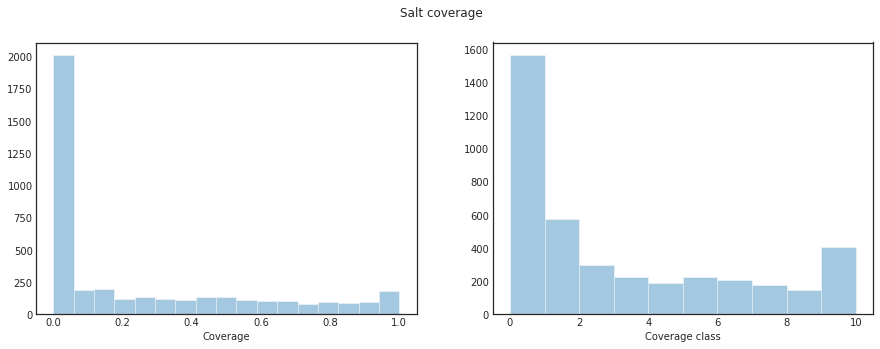

In [15]:
plot_coverage_and_coverage_class(train_df.coverage, train_df.coverage_class)

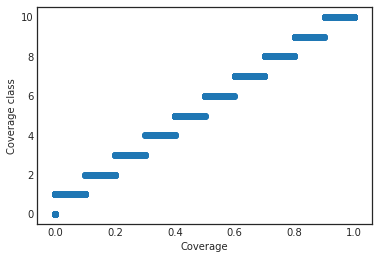

In [16]:
scatter_coverage_and_coverage_class(train_df.coverage, train_df.coverage_class)

/opt/conda/envs/py3.6/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


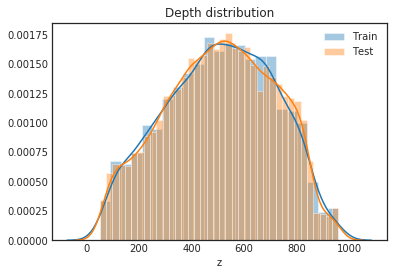

In [17]:
plot_depth_distributions(train_df.z, test_df.z)

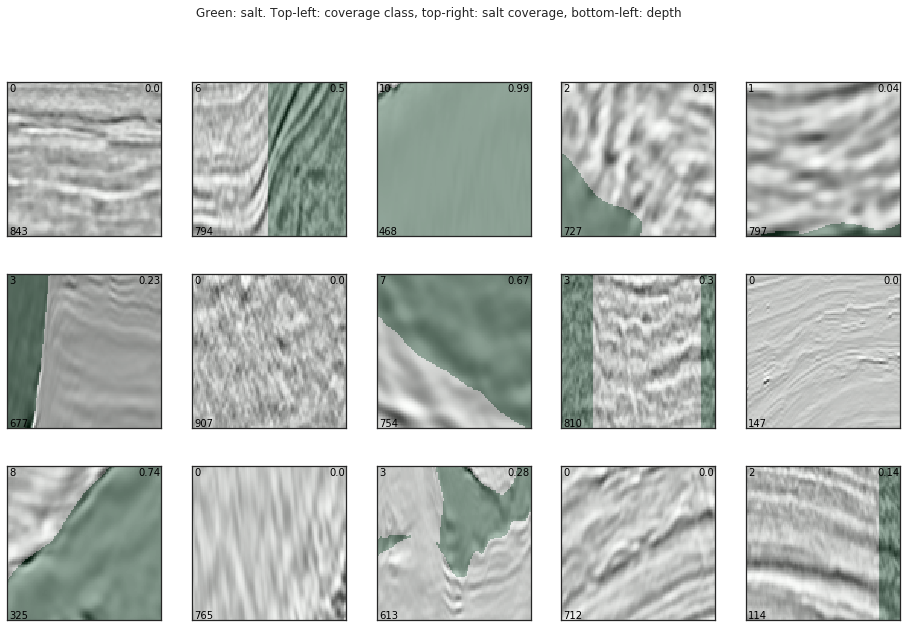

In [18]:
plot_images(train_df, max_images=15, grid_width=5, figsize=(16, 10))

In [19]:
upsample_to = upsample(101, img_size_target)

In [20]:
ids_train, ids_valid, x_train, x_valid, y_train, y_valid, cov_train, cov_test, depth_train, depth_test = train_test_split(
    train_df.index.values,
    np.array(train_df.images.map(upsample_to).tolist()).reshape(
        -1, 1, img_size_target, img_size_target
    ),
    np.array(train_df.masks.map(upsample_to).tolist()).reshape(
        -1, 1, img_size_target, img_size_target
    ),
    train_df.coverage.values,
    train_df.z.values,
    test_size=0.2,
    stratify=train_df.coverage_class,
    random_state=seed,
)

In [21]:
# Augment data with flipped verisons
x_train = np.append(x_train, [np.fliplr(x) for x in x_train], axis=0)
y_train = np.append(y_train, [np.fliplr(x) for x in y_train], axis=0)

In [22]:
x_train.shape

(6400, 1, 101, 101)

In [23]:
dataset = TGSSaltDataset(x_train, y_data=y_train)
dataset_val = TGSSaltDataset(x_valid, y_data=y_valid)

In [24]:
state = {
    "state_dict": None,
    "optimizer": None,
    "epoch": 0,
    "val_iou": 0,
    "best_val_iou": 0,
    "best_epoch": 0,
}

In [25]:
train_data_loader = data.DataLoader(
    dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=num_workers,
    pin_memory=True,
    drop_last=True,
)
val_data_loader = data.DataLoader(
    dataset_val,
    batch_size=batch_size,
    shuffle=False,
    num_workers=num_workers,
    pin_memory=True,
    drop_last=False,
)

In [26]:
config["optim_config"]["steps_per_epoch"] = len(train_data_loader)

In [ ]:
history = defaultdict(list)
loss_fn = torch.nn.BCELoss()

global_counter = it.count()
cumulative_epochs_counter = it.count()
cycle_best_val_iou = {}
for cycle in range(num_cycles):  # Cosine annealing with warm restarts
    optimizer, scheduler = create_optimizer(model.parameters(), config["optim_config"])
    for epoch in range(epochs):
        cum_epoch = next(cumulative_epochs_counter)
        train_metrics = train(
            cum_epoch,
            model,
            optimizer,
            scheduler,
            loss_fn,
            train_data_loader,
            config,
            summary_writer=summary_writer,
            global_counter=global_counter,
        )

        val_metrics = test(
            cum_epoch, model, loss_fn, val_data_loader, summary_writer=summary_writer
        )

        state = update_state(
            state, cum_epoch, "val_iou", np.mean(val_metrics["iou"]), model, optimizer
        )

        save_checkpoint(state, best_model_filename=f"model_{cycle}_best_state.pth")

        history["epoch"].append(cum_epoch)
        history["train_loss"].append(np.mean(train_metrics["loss"]))
        history["val_loss"].append(np.mean(val_metrics["loss"]))
        history["train_iou"].append(np.mean(train_metrics["iou"]))
        history["val_iou"].append(np.mean(val_metrics["iou"]))
    cycle_best_val_iou[cycle] = state["best_val_iou"]

In [ ]:
sorted_by_val_iou = sorted(cycle_best_val_iou.items(), key=itemgetter(1), reverse=True)
best_cycle, best_iou = sorted_by_val_iou[0]
logger.info(f"Best model cycle {best_cycle}: Validation IoU {best_iou}")
logger.info("Saving to model_best_state.pth")
shutil.copy(
    os.path.join(model_path(), f"model_{best_cycle}_best_state.pth"),
    os.path.join(model_path(), f"model_best_state.pth"),
)

In [ ]:
fig, (ax_loss, ax_iou) = plt.subplots(1, 2, figsize=(15, 5))
ax_loss.plot(history["epoch"], history["train_loss"], label="Train loss")
ax_loss.plot(history["epoch"], history["val_loss"], label="Validation loss")
ax_loss.legend()
ax_iou.plot(history["epoch"], history["train_iou"], label="Train IoU")
ax_iou.plot(history["epoch"], history["val_iou"], label="Validation IoU")
ax_iou.legend()

In [28]:
filename = os.path.join(model_path(), "model_best_state.pth")
checkpoint = torch.load(filename)
model.load_state_dict(checkpoint["state_dict"])

In [29]:
def predict_tta(model, image):  # predict both orginal and reflect x
    with torch.no_grad():
        image_reflect = np.flip(image.numpy(), axis=3).copy()
        with torch.cuda.device(0):
            image_gpu = image.type(torch.float).cuda()
            image_reflect_gpu = torch.as_tensor(image_reflect).type(torch.float).cuda()

        outputs = model(image_gpu)
        outputs_reflect = model(image_reflect_gpu)
        return (
            outputs.cpu().numpy() + np.flip(outputs_reflect.cpu().numpy(), axis=3)
        ) / 2

In [30]:
model.eval()
predictions = [predict_tta(model, image) for image, _ in tqdm(val_data_loader)]

100%|██████████| 7/7 [00:02<00:00,  3.11it/s]


In [31]:
preds_valid = np.concatenate(predictions, axis=0).squeeze()

In [32]:
downsample_to = downsample(128, 101)

In [33]:
preds_valid = np.array(list(map(downsample_to, preds_valid)))

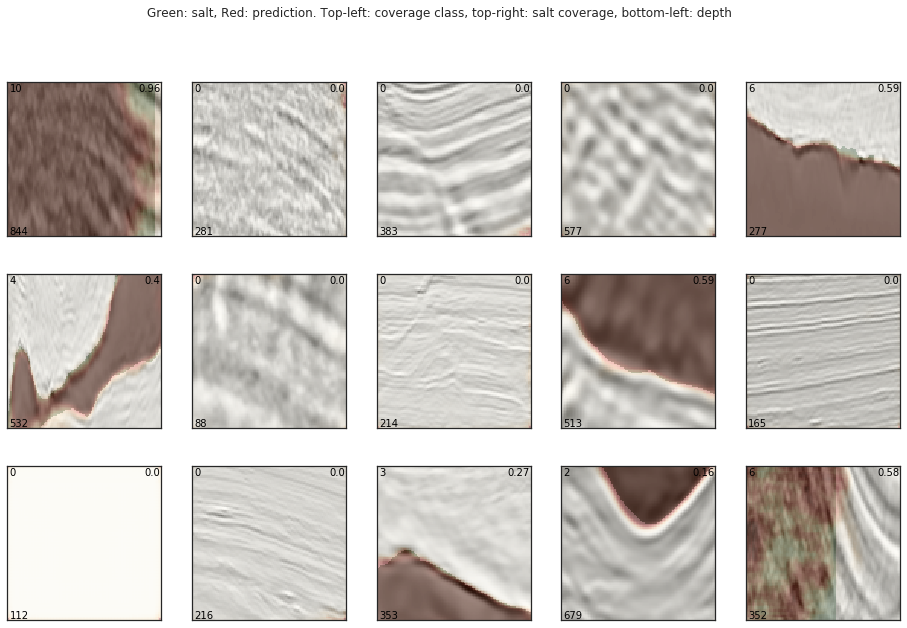

In [34]:
plot_predictions(
    train_df, preds_valid, ids_valid, max_images=15, grid_width=5, figsize=(16, 10)
)

In [35]:
## Scoring for last model, choose threshold using validation data
thresholds = np.linspace(0.3, 0.7, 31)
y_valid_down = np.array(list(map(downsample_to, y_valid.squeeze())))

ious = list(
    map(
        lambda th: iou_metric_batch(y_valid_down, np.int32(preds_valid > th)),
        tqdm(thresholds),
    )
)

100%|██████████| 31/31 [00:34<00:00,  1.09s/it]


In [36]:
threshold_best_index = np.argmax(ious)
iou_best = ious[threshold_best_index]
threshold_best = thresholds[threshold_best_index]

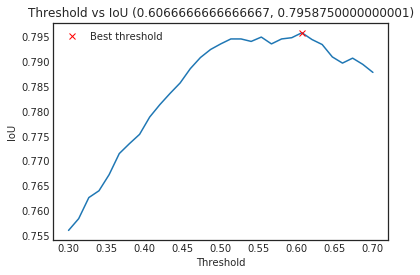

In [37]:
plt.plot(thresholds, ious)
plt.plot(threshold_best, iou_best, "xr", label="Best threshold")
plt.xlabel("Threshold")
plt.ylabel("IoU")
plt.title("Threshold vs IoU ({}, {})".format(threshold_best, iou_best))
plt.legend()

In [38]:
preds_thresh_iter = map(
    lambda pred: np.array(np.round(pred > threshold_best), dtype=np.float32),
    preds_valid,
)
preds_thresh = np.array(list(map(downsample_to, preds_thresh_iter)))

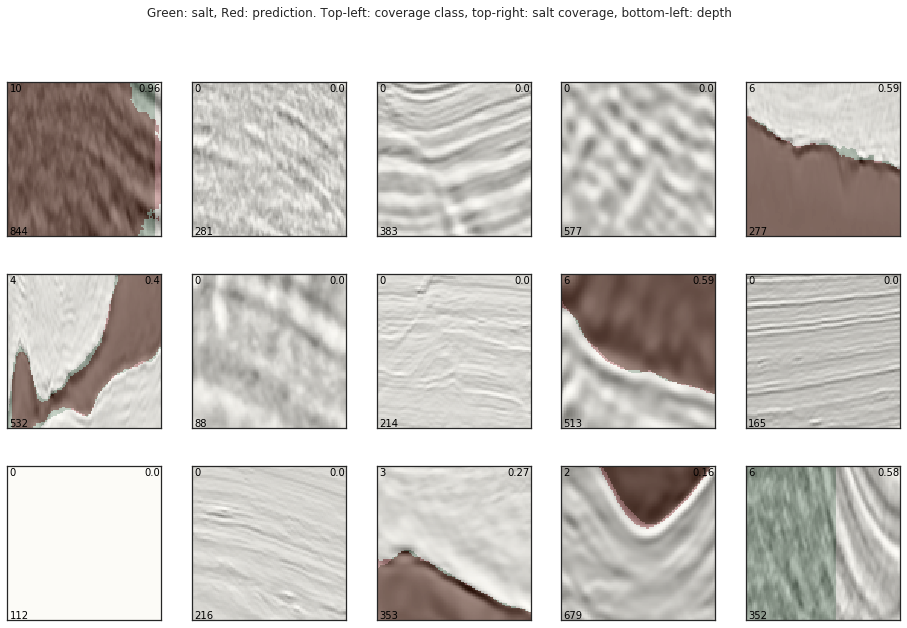

In [39]:
plot_predictions(
    train_df, preds_thresh, ids_valid, max_images=15, grid_width=5, figsize=(16, 10)
)

In [40]:
# We replace the final sigmoid layer with an identity function
model.module.final_activation = (
    Sequential()
)  # For model wrapped in data parallel we need the module qualifier
# The output now will be centered around zero and unsquashed so we also need to modify the iou metric
metrics = (("iou", my_iou_metric(threshold=0)),)  #

In [41]:
state = {
    "state_dict": None,
    "optimizer": None,
    "epoch": 0,
    "val_iou": 0,
    "best_val_iou": 0,
    "best_epoch": 0,
}

In [42]:
optim_config = {
    "optimizer": "sgd",
    "base_lr": 0.01,
    "momentum": 0.9,
    "weight_decay": 1e-4,
    "nesterov": True,
    "epochs": epochs,
    "scheduler": "cosine",
    "lr_min": 0,
    "steps_per_epoch": len(train_data_loader),
}

In [ ]:
lovasz_history = defaultdict(list)
loss_fn = lovasz_hinge

global_counter = it.count()
cumulative_epochs_counter = it.count()
cycle_best_val_iou = {}
for cycle in range(num_cycles):  # Cosine annealing with warm restarts
    optimizer, scheduler = create_optimizer(model.parameters(), optim_config)
    for epoch in range(epochs):
        cum_epoch = next(cumulative_epochs_counter)
        train_metrics = train(
            cum_epoch,
            model,
            optimizer,
            scheduler,
            loss_fn,
            train_data_loader,
            config,
            summary_writer=summary_writer,
            global_counter=global_counter,
            metrics_funcs=metrics,
        )

        val_metrics = test(
            cum_epoch,
            model,
            loss_fn,
            val_data_loader,
            summary_writer=summary_writer,
            metrics_funcs=metrics,
        )

        state = update_state(
            state, cum_epoch, "val_iou", np.mean(val_metrics["iou"]), model, optimizer
        )

        save_checkpoint(
            state, best_model_filename=f"model_lovasz_{cycle}_best_state.pth"
        )

        lovasz_history["epoch"].append(cum_epoch)
        lovasz_history["train_loss"].append(np.mean(train_metrics["loss"]))
        lovasz_history["val_loss"].append(np.mean(val_metrics["loss"]))
        lovasz_history["train_iou"].append(np.mean(train_metrics["iou"]))
        lovasz_history["val_iou"].append(np.mean(val_metrics["iou"]))
    cycle_best_val_iou[cycle] = state["best_val_iou"]

In [ ]:
sorted_by_val_iou = sorted(cycle_best_val_iou.items(), key=itemgetter(1), reverse=True)
best_cycle, best_iou = sorted_by_val_iou[0]
logger.info(f"Best model cycle {best_cycle}: Validation IoU {best_iou}")
logger.info("Saving to model_lovasz_state.pth")
shutil.copy(
    os.path.join(model_path(), f"model_lovasz_{best_cycle}_best_state.pth"),
    os.path.join(model_path(), f"model_lovasz__best_state.pth"),
)

In [ ]:
fig, (ax_loss, ax_iou) = plt.subplots(1, 2, figsize=(15, 5))
ax_loss.plot(lovasz_history["epoch"], lovasz_history["train_loss"], label="Train loss")
ax_loss.plot(
    lovasz_history["epoch"], lovasz_history["val_loss"], label="Validation loss"
)
ax_loss.legend()
ax_iou.plot(lovasz_history["epoch"], lovasz_history["train_iou"], label="Train IoU")
ax_iou.plot(lovasz_history["epoch"], lovasz_history["val_iou"], label="Validation IoU")
ax_iou.legend()

In [ ]:
filename = os.path.join(model_path(), "model_lovasz__best_state.pth")
checkpoint = torch.load(filename)
model.load_state_dict(checkpoint["state_dict"])

In [ ]:
model.eval()
predictions = [predict_tta(model, image) for image, _ in tqdm(val_data_loader)]

preds_valid = np.concatenate(predictions, axis=0).squeeze()
downsample_to = downsample(128, 101)
preds_valid = np.array(list(map(downsample_to, preds_valid)))
plot_predictions(
    train_df, preds_valid, ids_valid, max_images=15, grid_width=5, figsize=(16, 10)
)

In [ ]:
## Scoring for last model, choose threshold using validation data
thresholds = np.linspace(0.3, 0.7, 31)
y_valid_down = np.array(list(map(downsample_to, y_valid.squeeze())))
thresholds = np.log(thresholds / (1 - thresholds))

ious = list(
    map(
        lambda th: iou_metric_batch(y_valid_down, np.int32(preds_valid > th)),
        tqdm(thresholds),
    )
)

threshold_best_index = np.argmax(ious)
iou_best = ious[threshold_best_index]
threshold_best = thresholds[threshold_best_index]

Text(0.5, 1.0, 'Threshold vs IoU (0.2141479884056315, 0.8075)')

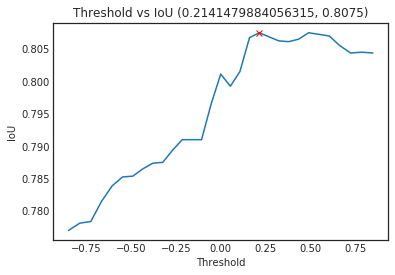

In [67]:
plt.plot(thresholds, ious)
plt.plot(threshold_best, iou_best, "xr", label="Best threshold")
plt.xlabel("Threshold")
plt.ylabel("IoU")
plt.title("Threshold vs IoU ({}, {})".format(threshold_best, iou_best))

In [ ]:
preds_thresh_iter = map(
    lambda pred: np.array(np.round(pred > threshold_best), dtype=np.float32),
    preds_valid,
)

plot_predictions(
    train_df, preds_thresh, ids_valid, max_images=15, grid_width=5, figsize=(16, 10)
)
preds_thresh = np.array(list(map(downsample_to, preds_thresh_iter)))
plt.legend()

In [69]:
x_test = load_images_as_arrays(test_df.index, test_images_path())
x_test = list(map(upsample_to, x_test))
x_test = np.array(x_test).reshape(-1, 1, img_size_target, img_size_target)

100%|██████████| 18000/18000 [00:14<00:00, 1273.20it/s]


In [ ]:
dataset_test = TGSSaltDataset(x_test, is_test=True)

In [ ]:
test_data_loader = data.DataLoader(
    dataset_test,
    batch_size=batch_size,
    shuffle=False,
    num_workers=num_workers,
    pin_memory=True,
    drop_last=False,
)

In [ ]:
model.eval()
predictions = [predict_tta(model, image) for image in tqdm(test_data_loader)]

In [73]:
preds_test = np.concatenate(predictions, axis=0).squeeze()

In [ ]:
transform = compose(rle_encode, np.round, downsample_to, lambda x: x > threshold_best)

In [ ]:
pred_dict = {
    idx: transform(preds_test[i]) for i, idx in enumerate(tqdm(test_df.index.values))
}

In [ ]:
sub = pd.DataFrame.from_dict(pred_dict, orient="index")
sub.index.names = ["id"]
sub.columns = ["rle_mask"]
filename = os.path.join(model_path(), f"submission_{now:%d%b%Y_%H}.csv")
sub.to_csv(filename)